In [1]:
%%bash
# remove everything except this notebook
shopt -s extglob
rm -rf !("notebook.ipynb") 
# to test any error in the terminal, use:
# ipython3 -c "%run notebook.ipynb"

In [2]:
# create empty directories
!mkdir raw_ligands
!mkdir prepared_ligands

In [ ]:
# put some raw ligand files into the "raw_ligands" directory
# -P prefix --directory-prefix=prefix Set directory prefix to prefix.
!rm raw_ligands/*
!wget -P raw_ligands/ https://raw.githubusercontent.com/ccsb-scripps/AutoDock-Vina/develop/example/basic_docking/data/1iep_ligand.sdf
!wget -O raw_ligands/1iep_ligand_G_STI.sdf "https://models.rcsb.org/v1/1iep/ligand?auth_seq_id=201&label_asym_id=G&encoding=sdf&filename=1iep_G_STI.sdf"
!ls raw_ligands/

check the protonation state of the molecules before docking
> In chemistry, protonation (or hydronation) is the adding of a proton (or hydron, or hydrogen cation), (H+) to an atom, molecule, or ion, forming a conjugate acid. (The complementary process, when a proton is removed from a Brønsted–Lowry acid, is deprotonation.)

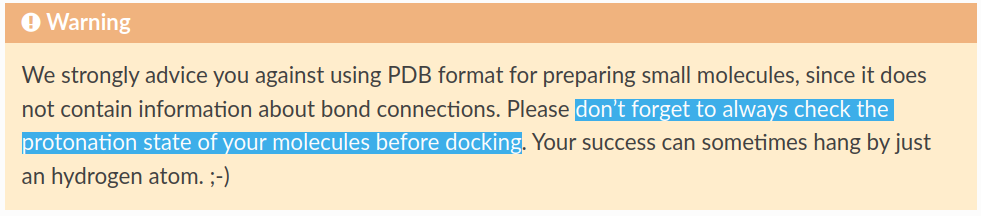

In [31]:
%%file check_ligand_protonation.py
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
Check the protonation state of the molecules before docking.
In chemistry, protonation (or hydronation) is the adding of a proton (or hydron, or hydrogen cation), (H+) to an atom, molecule, or ion, forming a conjugate acid. (The complementary process, when a proton is removed from a Brønsted–Lowry acid, is deprotonation.)
Usage:
    bash check_ligand_protonation.sh <input file> <output file>
Example:
    bash check_ligand_protonation.sh 1iep_ligand_G_STI.sdf ligand_step01_protonated.sdf
"""

import os
import sys


__author__ = "Carlos Garcia-Hernandez"
__email__ = "carlos.garcia2@bsc.es"

USAGE = __doc__.format(__author__, __email__)

def check_input(args):
    """Validates user input/options.
    """
    if not os.path.isfile(args):
            emsg = 'ERROR!! File not found or not readable: \'{}\'\n'
            sys.stderr.write(emsg.format(args[0]))
            sys.stderr.write(__doc__)
            sys.exit(1)
    return args

def run(infile, outfile):
    """
    Check the protonation state of the molecules before docking.
    Parameters
    ----------
    fhandle : an iterable giving the PDB file line-by-line
    outname : str
        The base name of the output files. If None is given, tries to
        extract a name from the `.name` attribute of `fhandler`. If
        `fhandler` has no attribute name, assigns `splitchains`.
    """
    from openbabel import openbabel as ob
    from meeko import obutils

    mol = obutils.load_molecule_from_file(infile, molecule_format='SDF')

    mol.AddHydrogens()
    charge_model = ob.OBChargeModel.FindType("Gasteiger")
    charge_model.ComputeCharges(mol)

    obutils.writeMolecule(mol, fname=outfile)


def main():
    # Check Input
    args = sys.argv[1:]
    infile = check_input(args[0])
    outfile = args[1]

    # Do the job
    run(infile, outfile)

    # last line of the script
    # We can close it even if it is sys.stdin
    # infile.close()
    # outfile.close()
    sys.exit(0)


if __name__ == '__main__':
    main()

# --------------------------------------------------------------------------
# references:
# add hydrogens to molecules using openbabel
# from: https://github.com/DrrDom/rdkit-scripts/blob/master/vina_dock.py
#       https://github.com/forlilab/Meeko/blob/09610111d43fef2b11636ddd110d1423205a3d47/meeko/utils/obutils.py


Overwriting check_ligand_protonation.py


In [9]:
%%file check_ligand_protonation.sh
#!/bin/bash

source /opt/conda/etc/profile.d/conda.sh
conda activate env_meeko
# mk_prepare_ligand.py $@
python check_ligand_protonation.py $@

Overwriting check_ligand_protonation.sh


In [10]:
!chmod 777 check_ligand_protonation.sh
!ls -l

total 112
-rw-r--r-- 1 jovyan users  2896 Apr 13 12:06 check_ligand_protonation.py
-rwxrwxrwx 1 jovyan users   143 Apr 13 12:06 check_ligand_protonation.sh
-rw-r--r-- 1 jovyan users 95305 Apr 13 12:05 notebook.ipynb
drwxr-xr-x 2 jovyan users  4096 Apr 12 17:12 prepared_ligands
drwxr-xr-x 2 jovyan users  4096 Apr 12 17:30 raw_ligands


In [26]:
# list files in directory
import glob, os
ligand_filepaths = sorted(glob.glob('raw_ligands/*'))
ligand_filenames = list(map(lambda x: os.path.splitext(os.path.basename(x))[0], ligand_filepaths))
ligand_filepaths

['raw_ligands/1iep_ligand.sdf', 'raw_ligands/1iep_ligand_G_STI.sdf']

In [54]:
!rm prepared_ligands/*
for i,ligand_filepath in enumerate(ligand_filepaths):
    print("\n", "-"*50, "\n\n", ligand_filepath, "\n")
    ligand_filename = ligand_filenames[i]; #print(ligand_filename)
    # -------------------------------------------------------------------------------
    # step01: check the protonation state of the molecules before docking
    step01_out = "prepared_ligands/" + ligand_filename +"_step01.sdf"
    !./check_ligand_protonation.sh {ligand_filepath} {step01_out}
    # -------------------------------------------------------------------------------
    # step02: change the format of the molecule to PDBQT
    step02_out = "prepared_ligands/" + ligand_filename + "_step02.pdbqt"
    !prepare_ligand -i {step01_out} -o {step02_out}
    # -------------------------------------------------------------------------------
    !mv {step02_out} "prepared_ligands/"{ligand_filename}".pdbqt"
    !rm prepared_ligands/*_step*
    # -------------------------------------------------------------------------------


 -------------------------------------------------- 

 raw_ligands/1iep_ligand.sdf 


 -------------------------------------------------- 

 raw_ligands/1iep_ligand_G_STI.sdf 



In [55]:
!ls prepared_ligands -l

total 8
-rw-r--r-- 1 jovyan users 3781 Apr 13 12:38 1iep_ligand_G_STI.pdbqt
-rw-r--r-- 1 jovyan users 3871 Apr 13 12:38 1iep_ligand.pdbqt
